In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pickle


In [4]:
df=pd.read_csv('Housing.csv')
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [5]:
df.shape

(545, 13)

In [6]:
df.isnull().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

In [7]:
df.nunique()

price               219
area                284
bedrooms              6
bathrooms             4
stories               4
mainroad              2
guestroom             2
basement              2
hotwaterheating       2
airconditioning       2
parking               4
prefarea              2
furnishingstatus      3
dtype: int64

In [8]:
numeric_cols=df.select_dtypes(include=np.number).columns.tolist()
categorical_cols=df.select_dtypes(include='object').columns.tolist()
print("numeric_cols=",numeric_cols)
print("categorical_cols=",categorical_cols)


numeric_cols= ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']
categorical_cols= ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']


In [9]:
binary_map = {'yes': 1, 'no': 0}
for col in ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']:
    df[col] = df[col].map(binary_map)

df = df[df['furnishingstatus'] != 'semi-furnished']
df['furnishingstatus'] = df['furnishingstatus'].map({'furnished': 1, 'unfurnished': 0})


In [10]:
df

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1
7,10150000,16200,5,3,2,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
539,1855000,2990,2,1,1,0,0,0,0,0,1,0,0
540,1820000,3000,2,1,1,1,0,1,0,0,2,0,0
542,1750000,3620,2,1,1,1,0,0,0,0,0,0,0
543,1750000,2910,3,1,1,0,0,0,0,0,0,0,1


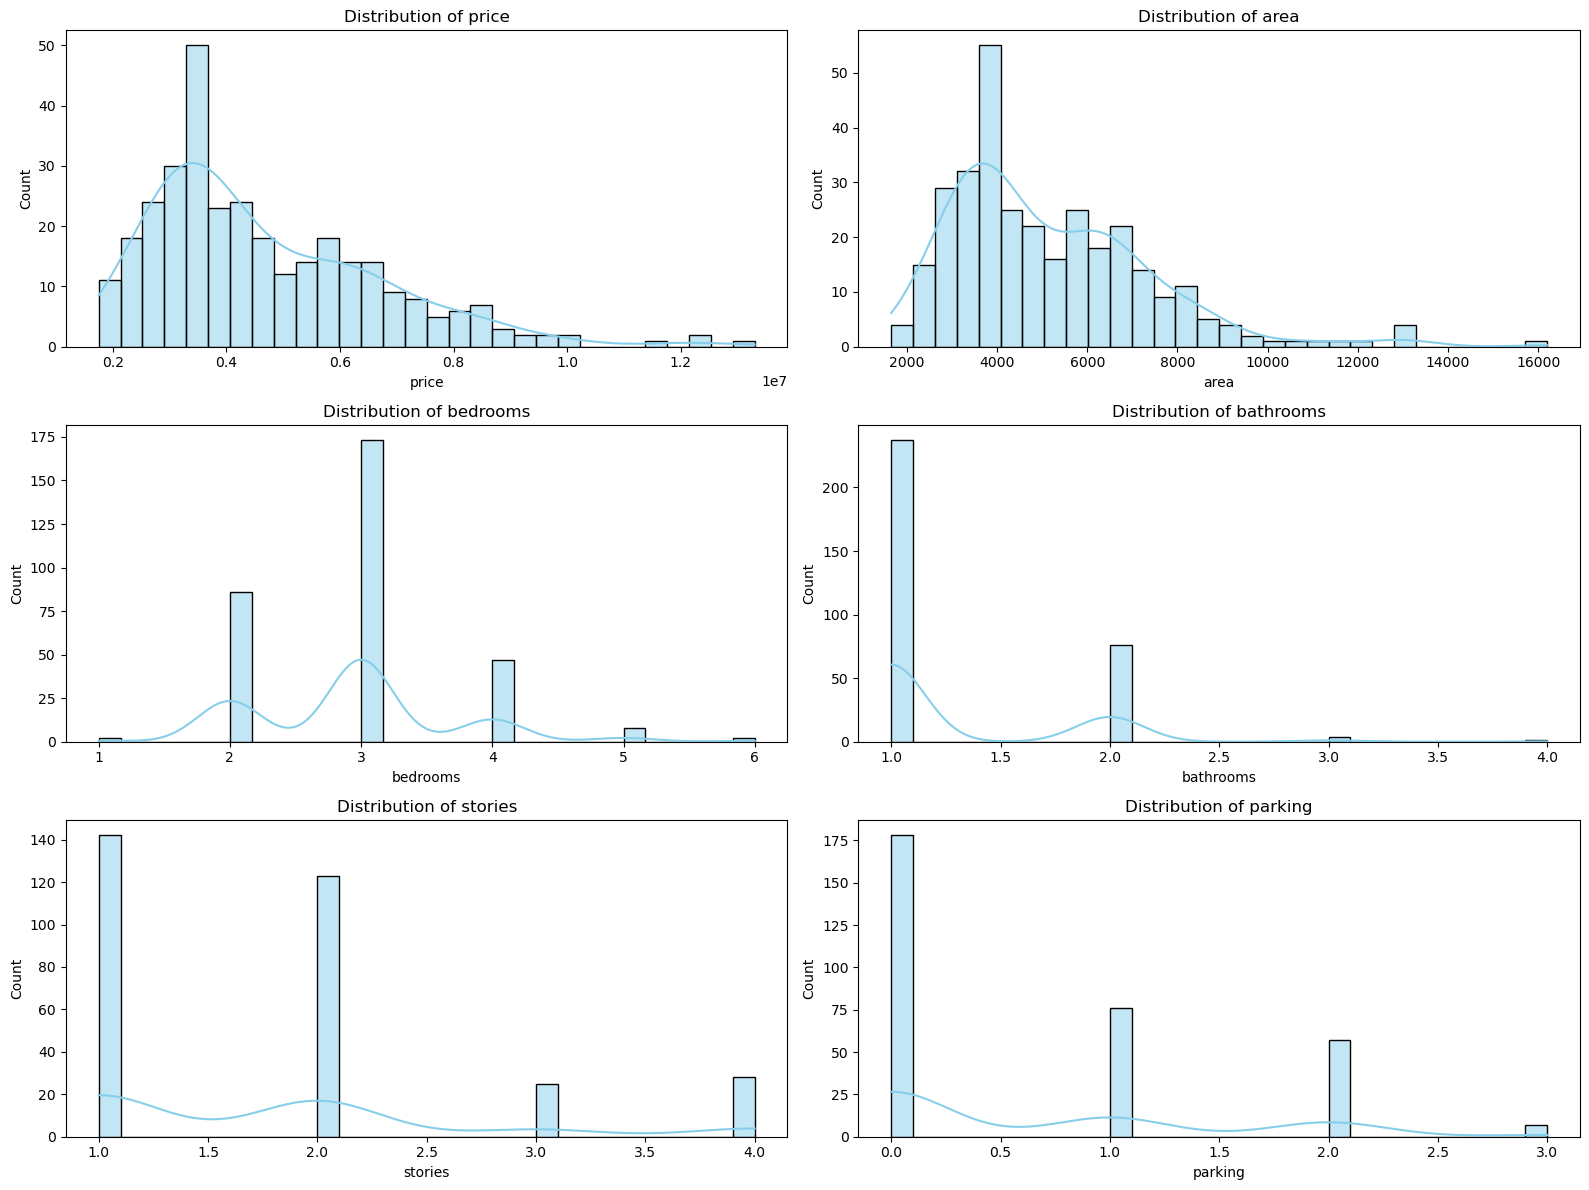

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Numeric columns
numeric_cols = ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']

# Plot distributions
plt.figure(figsize=(16, 12))
for i, col in enumerate(numeric_cols):
    plt.subplot(3, 2, i+1)
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


In [12]:
df[numeric_cols].skew()

price        1.173408
area         1.332112
bedrooms     0.690730
bathrooms    1.720377
stories      1.078553
parking      0.923369
dtype: float64

In [13]:
import numpy as np

numeric_cols = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']

for col in numeric_cols:
    df[col] = np.log1p(df[col])  # log(x + 1) to avoid log(0)
df[numeric_cols].skew()

area         0.133558
bedrooms    -0.009138
bathrooms    1.382533
stories      0.593150
parking      0.558712
dtype: float64

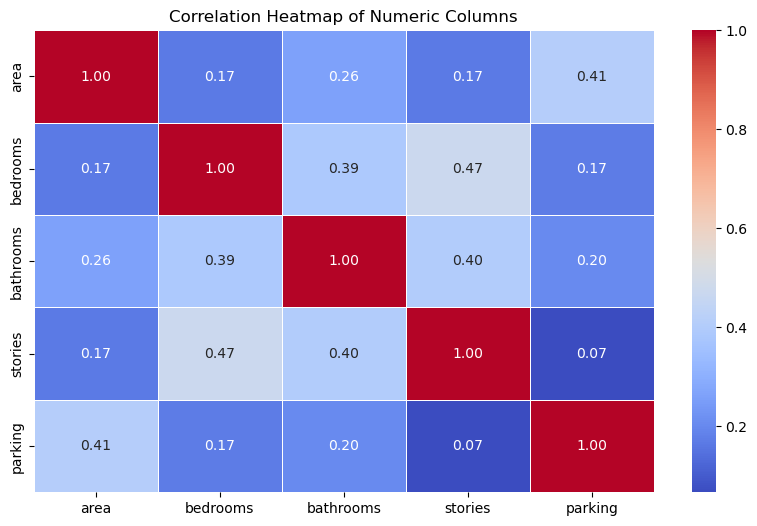

In [14]:
corr = df[numeric_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Columns")
plt.show()


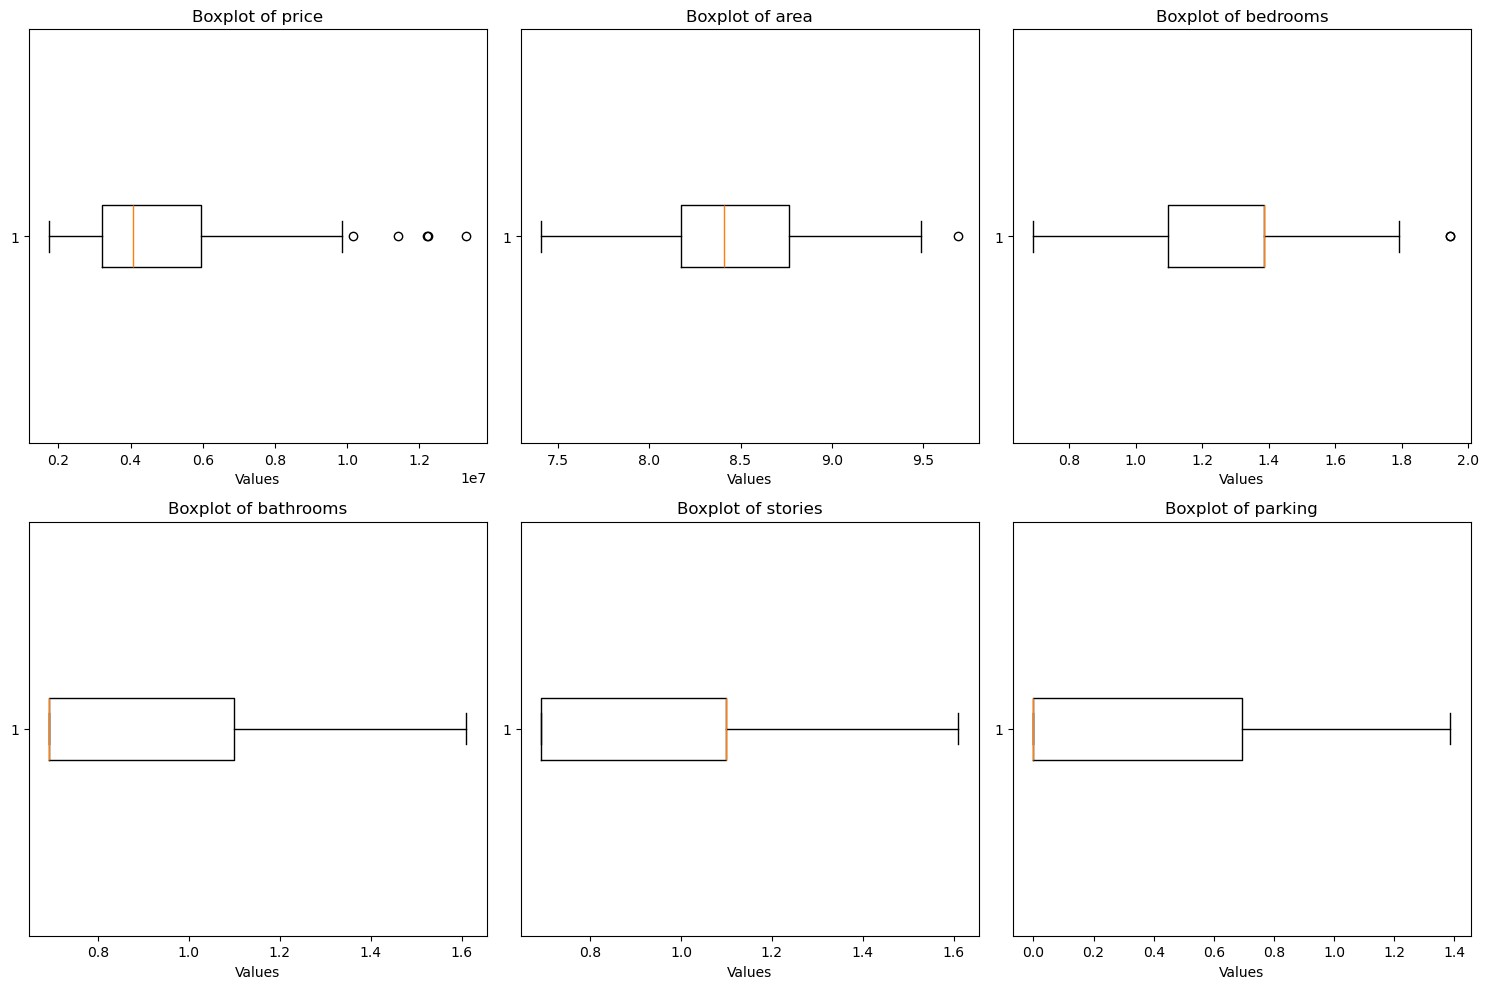

In [15]:
import matplotlib.pyplot as plt

numeric_cols = ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']

# Create subplots automatically
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows x 3 columns
axes = axes.flatten()

for ax, col in zip(axes, numeric_cols):
    ax.boxplot(df[col], vert=False)
    ax.set_title(f'Boxplot of {col}')
    ax.set_xlabel('Values')

# Hide unused axes (if any)
for ax in axes[len(numeric_cols):]:
    ax.axis('off')

plt.tight_layout()
plt.show()



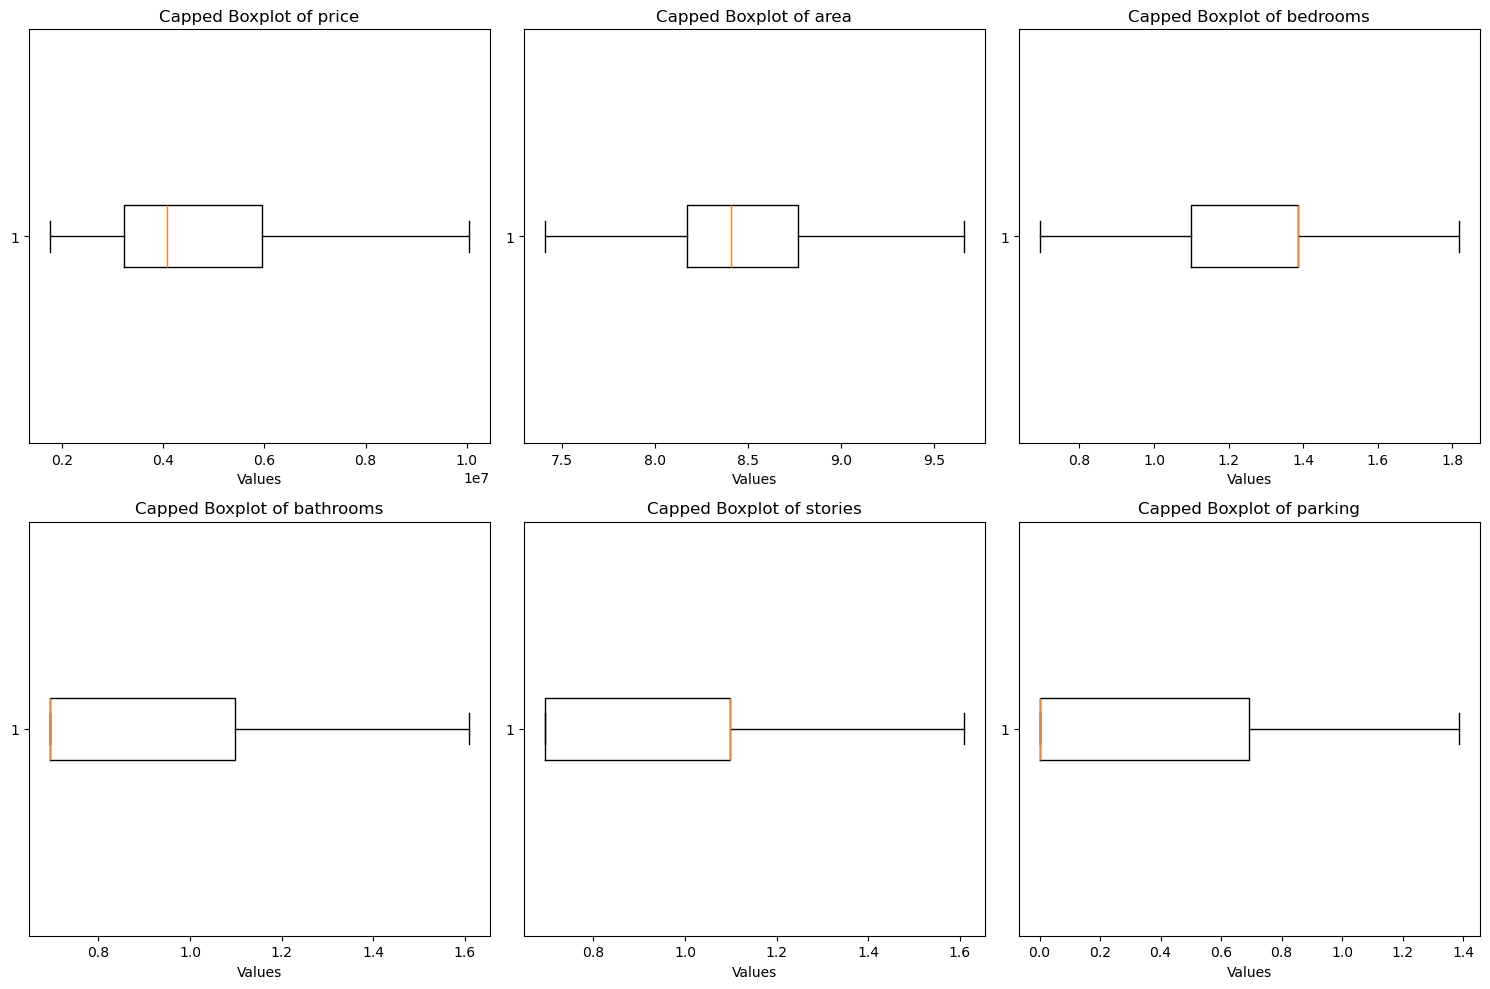

In [16]:
import matplotlib.pyplot as plt

numeric_cols = ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']

# Cap outliers using IQR method
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

# Plot updated boxplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows x 3 columns
axes = axes.flatten()

for ax, col in zip(axes, numeric_cols):
    ax.boxplot(df[col], vert=False)
    ax.set_title(f'Capped Boxplot of {col}')
    ax.set_xlabel('Values')

# Hide unused axes (if any)
for ax in axes[len(numeric_cols):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [18]:
X = df.drop('price', axis=1)
y = df['price']

numeric_cols = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
X[numeric_cols] = np.log1p(X[numeric_cols]) 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [19]:
X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsRegressor(n_neighbors=5)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = -cross_val_score(knn, X_train_scaled, y_train, cv=kf, scoring='neg_root_mean_squared_error')
print(f'5-Fold CV RMSE: {cv_scores.mean():.2f}')

knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)
print(f'Test RMSE: {test_rmse:.2f}')
print(f'Test R²: {test_r2:.2f}')


5-Fold CV RMSE: 1140567.06
Test RMSE: 1278540.10
Test R²: 0.57


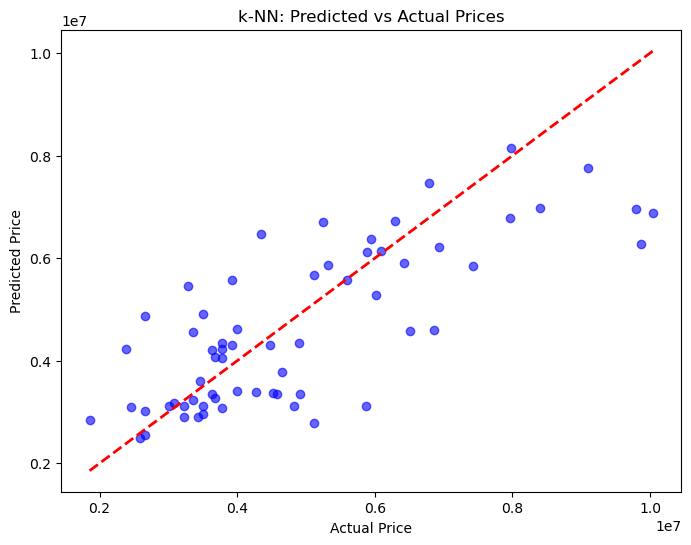

In [20]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('k-NN: Predicted vs Actual Prices')
plt.show()

In [21]:
import pickle


with open('knn_model.pkl', 'wb') as f:
    pickle.dump(knn, f)


with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Model and scaler saved successfully.")


Model and scaler saved successfully.
